In [25]:
import pandas
from scipy.spatial import cKDTree
import numpy as np
import sys
import pyfits
import argparse
import datetime
import time
from scipy.interpolate import interp1d

# sys.path.append("/Users/surhud/aum/aum/install/lib/python2.7/site-packages/")

%matplotlib inline

import pylab as pl
import palettable
colors = palettable.colorbrewer.qualitative.Dark2_8.mpl_colors

In [28]:
def getweaklensing_signal(rmin=0.1, rmax=80.0, rbin=15, pairout="debug_deltasigma.out", 
                          zminclus=0.40, zmaxclus=0.75, lamdamin=20.0, lamdamax=1000.0, shape=0, deltaz=0.2):

    logrmax = np.log10(rmax)
    logrmin = np.log10(rmin)
    logrdiff = (logrmax-logrmin)/rbin

    # Delta Sigma_tangential
    dsig_sum = np.zeros(rbin)
    # Delta Sigma_cross
    dsigcross_sum = np.zeros(rbin)
    # Lens source weight sum
    wls_sum = np.zeros(rbin)
    # Lens source weighting with the multiplicative bias factor sum
    wls_ms_sum = np.zeros(rbin)
    # The next term is for the boost factor correction
    dcount_sum = np.zeros(rbin)

    try:
        import cosmology as cc
        # Only important parameter here is Omega0, OmegaK, w0 and wa
        # Rest are unimportant but are: Omegab, hval, theta, sigma8, ns, ignore the rest
        Omega0 = 0.27
        OmegaK = 0.0
        w0 = -1.0
        wa = 0.0
        cosmo = cc.cosmology(Omega0, OmegaK, w0, wa, 0.0476, 0.7, 2.726, 0.8, 0.96, np.log10(8.0), 1.0)
    except:
        print "Could not import cosmology from aum, trying colossus instead"
        from colossus.cosmology import cosmology
        cosmo = cosmology.setCosmology('WMAP9')
    
    from code.setup import data_home_dir
    hdulist = pyfits.open(data_home_dir()+"des/redmapper_sva1_public_v6.3_catalog.fits")
    data = hdulist[1].data
    ra = data["ra"]
    dec = data["dec"]
    zred = data["z_lambda"].astype("float64")
    lamda = data["lambda"]
    wt = ra/ra

    # Filter the cluster catalog by zmin, zmax, lammin, lammax -- To be done
    idx = (zred>=zminclus) & (zred<=zmaxclus) & (lamda>=lamdamin) & (lamda<=lamdamax)
    ra = ra[idx]
    dec = dec[idx]
    zred = zred[idx]
    print "The number of clusters used are ", np.sum(idx), " from a total of ", idx.size

    # Convert to radians
    ra = ra * np.pi / 180.
    dec = dec * np.pi / 180.

    # cos(ra_lens), sin(ra_lens), sin(dec_lens), cos(dec_lens)
    c_lra=np.cos(ra)
    s_lra=np.sin(ra)
    s_ldec=np.sin(dec)
    c_ldec=np.cos(dec)

    # Unit vectors
    xx = c_ldec*c_lra
    yy = c_ldec*s_lra
    zz = s_ldec

    # For every zred compute the Comoving distance in hinv Mpc
    dCofzl = zred * 0.0
    
    for i in range(zred.size):
        try:
            dCofzl[i] = cosmo.Dcofz(zred[i])
        except:
            dCofzl[i] = cosmo.comovingDistance(0.0, zred[i])/cosmo.h
    
    #dCofzs = cosmo.comovingDistance(0.0, zred)/cosmo.h
    
    # The shape catalog has been written out as an ascii file to get serial access
    # Download from http://member.ipmu.jp/surhud.more/downloads/desdata.tgz
    if shape==0:
        dfchunks = pandas.read_csv(data_home_dir()+"des/sva1_gold_r1.1_im3shape_corr_flagged.dat", delim_whitespace=1, header=None, names=(["ra", "dec", "e_1corr", "e_2corr", "nbc_m", "w", "mean_photoz"]), chunksize=1000000)
    else:
        # Here nbc_m is actually sens_avg
        dfchunks = pandas.read_csv(data_home_dir()+"des/sva1_gold_r1.0_ngmix_corr_flagged.dat", delim_whitespace=1, header=None, names=(["ra", "dec", "e_1corr", "e_2corr", "nbc_m", "w", "mean_photoz"]), chunksize=1000000)

    itern=0
    for df in dfchunks:
        itern=itern+1
        tstamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
        sys.stderr.write("\n Processing chunk %d of the source file: %s\n"%(itern, tstamp))

        ragal  = df.ra.values * np.pi/180.0
        decgal = df.dec.values * np.pi/180.0
        zphotgal = df.mean_photoz.values
        e1gal = df.e_1corr.values
        e2gal = df.e_2corr.values
        if shape==0:
            mgal = df.nbc_m.values + 1.0
        else:
            mgal = df.nbc_m.values
        wgal = df.w.values

        dCofzs = zphotgal * 0.0
        
        for i in range(zphotgal.size):
            try:
                dCofzs[i] = cosmo.Dcofz(zphotgal[i])
            except:
                dCofzs[i] = cosmo.comovingDistance(0.0, zphotgal[i])/cosmo.h
        
        #dCofzs = cosmo.comovingDistance(0.0, zphotgal)/cosmo.h
        # Sigc_inv = 4piG/c^2 dL dLS/dS (1+zl)**2
        # First factor = 4piG/c^2 / dS
        gee = 4.3022682e-9
        cee = 299792.458
        sigc_inv_fac=1e12*4*np.pi*gee/(cee*cee)*(1+zphotgal)/dCofzs

        # cos(ra_source), sin(ra_source), sin(dec_source), cos(dec_source)
        c_sra=np.cos(ragal)
        s_sra=np.sin(ragal)
        s_sdec=np.sin(decgal)
        c_sdec=np.cos(decgal)

        xxgal = c_sdec*c_sra
        yygal = c_sdec*s_sra
        zzgal = s_sdec

        tree = cKDTree(zip(xxgal, yygal, zzgal))

        # For every galaxy cluster, query the sources around it
        import frogress
        for i in frogress.bar(range(ra.size)):
#        for i in range(ra.size):
#            if i%50 == 0:
#                print "working on cluster %d"%i
            ind = tree.query_ball_point([xx[i], yy[i], zz[i]], rmax/(dCofzl[i]))
            if len(ind)==0:
                continue
            else:
                pass

            if np.isscalar(ind):
                ind = [ind]
            ind = np.array(ind)
            # print "1:", ind

            # zphot should be larger than the lens redshift plus deltaz
            idx = (zphotgal[ind]>zred[i]+deltaz)
            ind = ind[idx]
            # Now compute the cos(angle)
            cosang = xx[i]*xxgal[ind] + yy[i]*yygal[ind] + zz[i]*zzgal[ind]
            # Comoving projected distance
            Rp = dCofzl[i] * np.arccos(cosang)
            idx = (Rp>rmin)&(Rp<rmax)

            # Now compute the bearing angles
            cos_alps_alpl=c_sra[ind][idx]*c_lra[i]+s_sra[ind][idx]*s_lra[i];
            sin_alps_alpl=s_sra[ind][idx]*c_lra[i]-c_sra[ind][idx]*s_lra[i];

            cosangle = cosang[idx]
            sinangle=np.sqrt(1-cosangle*cosangle);
            cosphi=c_ldec[i]*sin_alps_alpl/sinangle;
            sinphi=(-s_ldec[i]*c_sdec[ind][idx]+c_ldec[i]*s_sdec[ind][idx]*cos_alps_alpl)/sinangle;
            etan=-e1gal[ind][idx]*(2*cosphi*cosphi-1)+e2gal[ind][idx]*(2*sinphi*cosphi);
            ecross=e1gal[ind][idx]*(2*sinphi*cosphi)+e2gal[ind][idx]*(2*cosphi*cosphi-1);

            # Sigc_inv = 4piG/c^2 dL dLS/dS (1+zl)**2
            # First factor = 4piG/c^2 / dS
            # This is the second factor = dL dLS (1+zl)**2
            sigc_inv = sigc_inv_fac[ind][idx]*dCofzl[i]*(dCofzs[ind][idx]-dCofzl[i])/(1.+zphotgal[ind][idx])*(1+zred[i])

            # Now compute the weights
            wls = wgal[ind][idx]*wt[i]*pow(sigc_inv,2)
            oneplusmcorr = (mgal[ind][idx])

            # print "4:", Rp[idx]
            Rp = Rp[idx]

            # Finalize bins and all arrays
            logRp = np.log10(Rp)
            ibin = np.floor((logRp-logrmin)/logrdiff).astype(int)
            idx = (ibin>=0)&(ibin<rbin)
            ibin = ibin[idx]
            etan = etan[idx]
            ecross = ecross[idx]
            wls = wls[idx]
            sigc_inv = sigc_inv[idx]
            oneplusmcorr = oneplusmcorr[idx]
            for j in range(ibin.size):
                dsig_sum[ibin[j]] += (etan[j]*wls[j]/sigc_inv[j])
                dcount_sum[ibin[j]] += wt[i]
                dsigcross_sum[ibin[j]] += (ecross[j]*wls[j]/sigc_inv[j])
                wls_sum[ibin[j]] += (wls[j])
                wls_ms_sum[ibin[j]] += (wls[j]*oneplusmcorr[j])

    rpmin = 10.0**(logrmin+logrdiff*np.arange(rbin))
    rpmax = 10.0**(logrmin+logrdiff*(1+np.arange(rbin)))
    np.savetxt(pairout, np.transpose([logrmin+logrdiff*(0.5+np.arange(rbin)), 
                                      dsig_sum, wls_sum, wls_ms_sum, dsig_sum/wls_ms_sum, 
                                      wls_sum/np.sum(wt), rpmin/2.+rpmax/2., dsigcross_sum/wls_ms_sum, 
                                      dcount_sum/np.sum(wt)]), 
               header=" deltaz: %.3f   rmax: %.3f rmin: %.3f rbins: %.3f pairout: %s zminclus: %.3f zmaxclus: %.3f lamdamin: %.3f lamdamax: %.3f shape: %d \n log    (r), dSigma_sum, wls_sum, wls_ms_sum, Delta Sigma, Boost factor term, Average r, Delta Sigma cross" % (deltaz, rmax, rmin, rbin, pairout, zminclus, zmaxclus, lamdamin, lamdamax, shape))
    return rpmin/2+rpmax/2, dsig_sum/wls_ms_sum, dsigcross_sum/wls_ms_sum

In [29]:
rp, deltasigma, deltacross = getweaklensing_signal()

Could not import cosmology from aum, trying colossus instead
The number of clusters used are  493  from a total of  787
100.0% | [##########] | Progress: 493 / 493 | Time: 1min20s | ETA: --


 Processing chunk 1 of the source file: 2016-04-11 00:17:44

 Processing chunk 2 of the source file: 2016-04-11 00:20:15


100.0% | [##########] | Progress: 493 / 493 | Time: 3.2s | ETA: --


 Processing chunk 3 of the source file: 2016-04-11 00:22:19


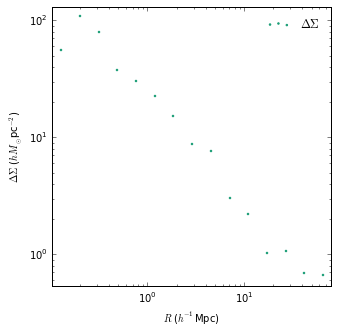

In [24]:
fig, ax = pl.subplots(figsize=(5,5))
ax.set_xlim(np.min(rp*0.8), np.max(rp*1.2))
ax.set_ylim(np.min(deltasigma*0.8), np.max(deltasigma*1.2))
ax.set_yscale("log"); ax.set_xscale("log")
ax.scatter(rp, deltasigma, color=colors[0], s=9, marker=".", label=r"$\Delta \Sigma$")
ax.set_xlabel(r"$R$ ($h^{-1}$Mpc)")
ax.set_ylabel(r"$\Delta\Sigma$ ($h M_\odot$pc$^{-2}$)")
ax.legend(loc=1, frameon=0)
# pl.savefig("Test.pdf")

In [22]:
print deltasigma

[  56.19855101  108.64426941   79.20553501   37.284788     30.10212335
   22.37685756   15.34565027    8.81625177    7.57125004    3.03447911
    2.23007298    1.02013426    1.06678235    0.68964962    0.67153341]
